In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from imblearn.datasets import make_imbalance

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

In [ ]:
list_files = np.load('octmnist.npz')
for name in list_files:
  print(name)
  print(np.shape(list_files[name]))

train_images
(97477, 28, 28)
val_images
(10832, 28, 28)
test_images
(1000, 28, 28)
train_labels
(97477, 1)
val_labels
(10832, 1)
test_labels
(1000, 1)


In [ ]:
train_images = list_files['train_images']
train_labels = list_files['train_labels']

test_images = list_files['test_images']
test_labels = list_files['test_labels']

val_images = list_files['val_images']
val_labels = list_files['val_labels']

In [ ]:
x_train1 = train_images.reshape(97477, -1)
y_train1 = train_labels.reshape(97477, -1)

x_test1 = test_images.reshape(1000, -1)
y_test1 = test_labels.reshape(1000, -1)

x_val1 = val_images.reshape(10832, -1)
y_val1 = val_labels.reshape(10832, -1)

In [ ]:
x_train1 = (255 - x_train1).astype(np.int64)
x_test1 = (255 - x_test1).astype(np.int64)
x_val1 = (255 - x_val1).astype(np.int64)


In [ ]:
x_train1 = x_train1 / 255.
x_test1 = x_test1 / 255.
x_val1 = x_val1 / 255.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [ ]:
lr_model_final = LogisticRegression(
    penalty = 'l2',
    C = 0.01,
    solver = 'newton-cg',
    warm_start = True,
    n_jobs = -1,
    random_state = 30,
    multi_class = 'ovr'
)

select_lr_final = SelectFromModel(
    lr_model_final,
    threshold = 'median'
)



In [ ]:
sel_x_train_final_weight = select_lr_final.fit_transform(x_train1, y_train1)
sel_x_test_final_weight = select_lr_final.transform(x_test1)


In [ ]:

lr_rf_model_final_weight = RandomForestClassifier(
          criterion = 'entropy',
          max_depth = None,
          n_estimators = 1000,
          n_jobs = -1,
          random_state = 35,
          class_weight = 'balanced'
      )

In [ ]:
lr_rf_model_final_weight.fit(sel_x_train_final_weight, y_train1)
rf_model1_pred_weight = lr_rf_model_final_weight.predict(sel_x_test_final_weight)

<Figure size 1800x1800 with 0 Axes>

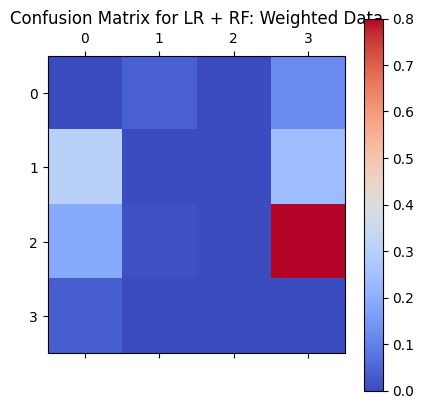

In [ ]:
CM_lr_rf_weight = confusion_matrix(y_test1, rf_model1_pred_weight)

CM_lr_rf_weight = CM_lr_rf_weight.astype('float') / CM_lr_rf_weight.sum(axis=1)[:, np.newaxis]

np.fill_diagonal(CM_lr_rf_weight,0)
plt.figure(1, figsize = (18,18))
plt.matshow(CM_lr_rf_weight, cmap=plt.cm.coolwarm)
plt.title('Confusion Matrix for LR + RF: Weighted Data')
plt.tight_layout
plt.colorbar()
plt.show()
                          

In [ ]:
acc1 = accuracy_score(y_test1, rf_model1_pred_weight)
pre1 = precision_score(y_test1, rf_model1_pred_weight, average= 'macro')
rec1 = recall_score(y_test1, rf_model1_pred_weight, average='macro')
f11 = f1_score(y_test1, rf_model1_pred_weight, average= 'macro')

print(acc1, pre1, rec1, f11)

0.566 0.4920334793568545 0.5660000000000001 0.4840707493349233


In [ ]:
rf_model1_proba_weight = lr_rf_model_final_weight.predict_proba(sel_x_test_final_weight)

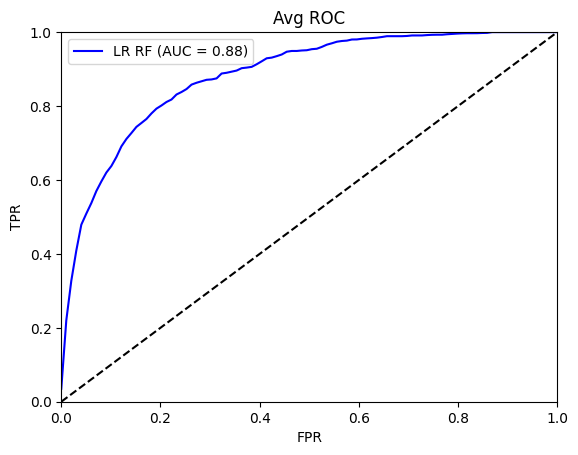

In [ ]:
Y_binary1 = label_binarize(y_test1, classes=[0,1,2,3])

plt.figure()
plt.clf()
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Avg ROC')

Fpr_mean = np.linspace(0,1,100)


classifier1 = rf_model1_proba_weight
labelval = 'LR RF'
color = 'b'


tpr_mean = []

for j in range(0, np.size(Y_binary1, 1)):
  fpr, tpr, T = roc_curve(Y_binary1[:,j], classifier1[:,j])
  tpr_mean.append(np.interp(Fpr_mean, fpr, tpr))
Tpr_mean = np.mean(tpr_mean, axis=0)
mean_auc = auc(Fpr_mean, Tpr_mean)
plt.plot(Fpr_mean, Tpr_mean, color=color, label= r'%s (AUC = %0.2f)' % (labelval,mean_auc))

plt.legend()
plt.show()

In [ ]:
from pylab import *

figure()
gray()
contour()